In [5]:
from tensorflow import keras
import numpy as np
import random
from tensorflow.image import resize
import cv2
from itertools import islice
#from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from keras.models import load_model
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
%matplotlib inline
import copy
import tensorflow as tf
from tensorflow.keras import backend as K
import json, torch

### Functions

In [90]:
def resize_and_process_images_for_model(image_set, model):
    '''Function to resize image sets based on give model'''
    if model == 'lenet5':
        images_resized = np.expand_dims(image_set, axis=-1) # Add channel
        images_resized = images_resized.astype('float32') # convert image values from integers to floats
        images_resized = images_resized/255.0 # normalization
        images_resized = resize(images_resized, [32,32], antialias=True, method='bilinear') # resize
        images_resized = images_resized.numpy() # Need to convert to numpy to prevent error when using train_test_split()

    if model == 'vgg16':
        images_resized = np.expand_dims(image_set, axis=-1) #add new dimension at the end of the array shape.
        images_resized = np.repeat(images_resized, 3, axis=-1)  # Repeat the channel dimension three times
        images_resized = images_resized.astype('float32') # convert image values from integers to floats
        images_resized = images_resized/255.0 # normalization
        images_resized = resize(images_resized, [48,48], antialias=True, method='bilinear') # resize
        images_resized = images_resized.numpy() # Need to convert to numpy to prevent error when using train_test_split()

    return images_resized

def display_images(images, label):
    n_col = len(images)
    fig, axes = plt.subplots(1, n_col, figsize=(18,5))
    for i in range(n_col):
        image  = images[i]
        if image.shape == (32, 32, 1):
            cmap = 'gray'
            model_type = 'LeNet-5'
        elif image.shape == (48, 48, 3):
            cmap = None
            model_type = 'VGG16'
        axes[i].imshow(images[i], cmap=cmap)
        axes[i].set_title(f'{model_type} Input Image - Label {label}')
    
    plt.tight_layout()
    plt.show()

def display_adv_images(input_images, adv_images, input_labels, adv_labels, img_perts):
    n_rows = len(input_images)
    n_cols = 3
    fig = plt.figure(figsize=(10, 7)) 
    for i in range(n_rows):
        if input_images[i].shape == (32, 32, 1):
            cmap = 'gray'
            model_type = 'LeNet-5'
        elif input_images[i].shape == (48, 48, 3):
            cmap = None
            model_type = 'VGG16'
            
        fig.add_subplot(n_rows, n_cols, i+1)
        plt.imshow(input_images[i], cmap=cmap)
        plt.axis('off')
        plt.title(f'{model_type} Input Image - Label {input_labels[i]}')
        fig.add_subplot(n_rows, n_cols, i+2)
        plt.imshow(adv_images[i], cmap=cmap)
        plt.axis('off')
        plt.title(f'{model_type} Adv Image - Label {adv_labels[i]}')
        fig.add_subplot(n_rows, n_cols, i+3)
        plt.axis('off')
        plt.imshow(img_perts[i], cmap=cmap)
        plt.title(f'{model_type} Total Pert for Label {input_labels[i]}')


### Load and Build Models

In [7]:
#LeNet_model = load_model('./Models/model_LeNet_no_softmax.h5')
LeNet_model = load_model('./Models/model_LeNet_no_softmax.h5')

In [8]:
VGG16_model = load_model('./Models/model_VGG16_no_softmax.h5')

### Load MNIST Images

In [9]:
# Loading dataset from keras (ref: https://keras.io/api/datasets/mnist/)
(x_train,y_train),(x_test,y_test)= keras.datasets.mnist.load_data()

# Print shapes
print('x_train shape: ', x_train.shape) # Train images
print('y_train shape: ', y_train.shape) # Train Labels
print('x_test shape: ', x_test.shape) # Test images
print('y_test shape: ', y_test.shape) # Test labels

x_train shape:  (60000, 28, 28)
y_train shape:  (60000,)
x_test shape:  (10000, 28, 28)
y_test shape:  (10000,)


### Resize Images

In [10]:
# Resize training images for LeNet5
lenet_xtest = resize_and_process_images_for_model(x_test, 'lenet5')
print('lenet_xtest shape: ', lenet_xtest.shape)

lenet_xtest shape:  (10000, 32, 32, 1)


In [11]:
# Resize training images for VGG16
vgg16_xtest = resize_and_process_images_for_model(x_test, 'vgg16')
print('vgg16_xtest shape: ', vgg16_xtest.shape)

vgg16_xtest shape:  (10000, 48, 48, 3)


### Select Input Images

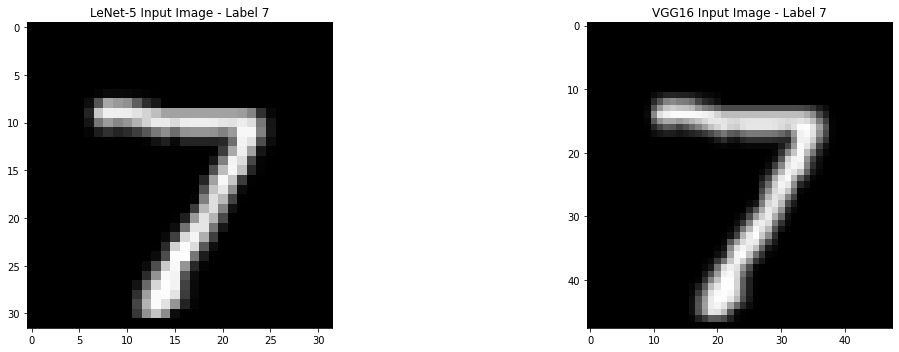

In [100]:
index = 0

# Select input image for LeNet and VGG16
lenet_input_img = lenet_xtest[index]
vgg16_input_img = vgg16_xtest[index]

# Grab label
input_label = y_test[index]

# Preview selected input images
prev_imgs = [lenet_input_img, vgg16_input_img]
display_images(prev_imgs, input_label)

### Deep Fool Attack

In [108]:
def deepfool_attack(model, input_images, max_iter=50, overshoot=0.01):
    # Intializes arrays to store final values
    images_adv = []
    images_pert = []
    labels_adv = []
    iters = []
    orig_labels = []
    
    # Create labels list for all possible classes (0 to 9)
    all_labels = tf.range(10, dtype=tf.int32) # Needs to be int32 or int64 type for loss function
    #print('all_labels: ', all_labels)
    
    # Find the ideal perturbation on each inputted image
    for i in range(len(input_images)):
        
        # Grab image to perturb
        input_img = input_images[i]
        
        # Expand Image to batch size of 1 for model input. e.g. (32, 32, 1) => (1, 32, 32, 1)
        x = tf.expand_dims(input_img, axis=0)

        # Copy image to perturb
        x_pert = copy.deepcopy(x)

        # Pert hat to go on image
        r_hat = tf.zeros_like(x)

        # Get the model logit values of the image and get predicted label
        k_0_logits = model(x)
        k_0 = np.argmax(k_0_logits) # predicted label for input image
        #print('The true input image label, k_0: ', k_0)

        # Initialize variable to store predicted labels after perturbation
        k_i = k_0
        
        # Create list of labels that are not the inputted image label
        k_wrong = all_labels[all_labels != k_0]
        #print('k_wrong: ', k_wrong)
        
        # Intialize count for storing how many iterations it took to find ideal perturbation
        count = 0
        
        # Find ideal perturbation. 
        #Break from loop if max_iter is reached or pert label not equal to true label
        for j in range(max_iter):
            if k_i != k_0: 
                break      

            w_ks = [] # Initialize array to store gradients
            
            # Compute the gradient of the loss function with respect to the pert image
            #  for each class
            for k in range(10):
                with tf.GradientTape() as tape:
                    x_pert = tf.convert_to_tensor(x_pert) # Convert to tensor to be used in tape.watch()
                    tape.watch(x_pert)
                    logits = model(x_pert, training=False)
                    label = tf.expand_dims(all_labels[k], axis=0) # Make rank = 1 for label input in loss e.g. (1,)
                    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=label, logits=logits)
                    w_k = tape.gradient(loss, x_pert)
                    w_ks.append(-w_k) # Add negative sign to move away from gradient
            f_k = tf.convert_to_tensor(logits) # conver to tensor
            w_ks = tf.convert_to_tensor(w_ks)  # convert to tensor
            #print('logits shape: ', f_k.shape)
            #print('gradients shape: ', w_ks.shape)

            # Initialize arrays to store values of gradients, logits, and perts
            perts = []
            w_k_diffs = []
            f_k_diffs = []

            # Compute the difference between gradient/logit values for the
            #  wrong labels and the gradient/logit value for the label 'k_0'
            for k in k_wrong:
                # Calculate difference between wrong class gradients and true class gradient
                w_k_diff = w_ks[k] - w_ks[k_0]
                # Calculate difference between wrong class logits and true class logits
                f_k_diff = f_k[0][k] - f_k[0][k_0]

                # Append values to array 
                w_k_diffs.append(w_k_diff)
                f_k_diffs.append(f_k_diff)

                # Apply L2 Norm to gradient difference
                w_k_diff_l2_norm = tf.sqrt(tf.reduce_sum(tf.square(w_k_diff), axis=[1, 2, 3]))
                # Compute the perturbation scalars 
                pert = tf.abs(f_k_diff) / w_k_diff_l2_norm
                perts.append(pert)

            w_k_diffs = tf.convert_to_tensor(w_k_diffs)
            f_k_diffs = tf.convert_to_tensor(f_k_diffs)
            perts = tf.convert_to_tensor(perts)   
            perts = tf.reshape(perts, [-1])
            #print('gradients differences: ', w_k_diffs.shape)
            #print('logits differences: ', f_k_diffs.shape)
            #print('perts shape: ', perts.shape)
            #print('perts ', perts)

            # get the index for the perturbation scalar that resulted in the smallest value
            pert_min_index = tf.math.argmin(perts, axis=0) 
            #print('pert_min_index: ', pert_min_index.numpy()) 

            # Compute the minimum perturbation and sum it with the previous
            # perturbations (Authors of paper did not mention a constant
            # added to the perturbation scalar, but it helps reduce the
            # number of iterations needed to fool the classifier)
            w_k_diff_l2_norm_at_pert_min = tf.sqrt(tf.reduce_sum(tf.square(w_k_diffs[pert_min_index]), axis=[1, 2, 3]))
            r_i = (perts[pert_min_index] + 1e-4) * w_k_diffs[pert_min_index] / w_k_diff_l2_norm_at_pert_min
            #print('r_i shape: ', r_i.shape)
            r_hat += r_i

            # Project the perturbation scaled with the overshoot
            # value over the input image
            x_pert = x + (1 + overshoot) * r_hat
            
            # Clip values to ensure image doesnt go out of bounds
            x_pert = tf.clip_by_value(x_pert, 0.0, 1.0)
    
            # Get the logit values of the aversarial image
            # and get the max confidence and predicted label
            adv_logits = model(x_pert)
            k_i = np.argmax(adv_logits) # Get predicted label of perturbed value 
            #print('adv predicted label_i: ', k_i)
            
            # Add count for iteration
            count += 1
        
        # Convert x_pert back to original image shape. e.g. (1, 32, 32, 1) + (32, 32, 1)
        x_pert = x_pert.numpy() # Convert back to numpy
        x_pert = np.squeeze(x_pert, axis=0) # Remove batch dimension
        images_adv.append(x_pert) # Convert image back to original shape and type

        # Convert total perturbation to original image shape
        total_pert = x_pert - x # This will be result of (1 + overshoot)*r_hat
        total_pert = total_pert.numpy() # Convert to numpy
        total_pert = np.squeeze(total_pert, axis=0) # remove batch dimension
        images_pert.append(total_pert) 
        labels_adv.append(k_i)
        iters.append(count)
        orig_labels.append(k_0)
        
    return orig_labels, images_adv, images_pert, labels_adv, iters


### Run Deep Fool Attack on LeNet Images

In [109]:
# Run Deep Fool on the selected input images
input_imgs = [lenet_input_img]
model = LeNet_model

lenet_orig_labels, lenet_adv_images, lenet_adv_perts, lenet_adv_labels, lenet_iterations = deepfool_attack(model, input_imgs)

### Display Attack

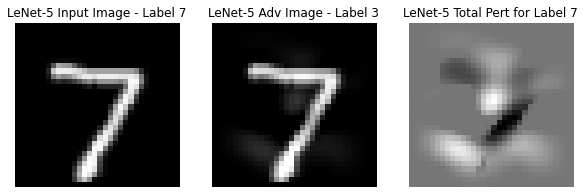

In [110]:
display_adv_images(input_imgs, lenet_adv_images, lenet_orig_labels, lenet_adv_labels, lenet_adv_perts)

### Attack on VGG16 Models

In [111]:
# Run Deep Fool on the selected input images
input_imgs = [vgg16_input_img]
model = VGG16_model

vgg16_orig_labels, vgg16_adv_images, vgg16_adv_perts, vgg16_adv_labels, vgg16_iterations = deepfool_attack(model, input_imgs)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


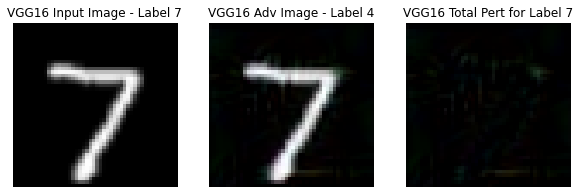

In [112]:
display_adv_images(input_imgs, vgg16_adv_images, vgg16_orig_labels, vgg16_adv_labels, vgg16_adv_perts)